# MiniLab: Logistic Regression and Support Vector Machines

In [1]:
import datetime
import itertools
import os
import pathlib
import sklearn

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
## from: https://www2.1010data.com/documentationcenter/prod/Tutorials/MachineLearningExamples/CensusIncomeDataSet.html
header_names = [
    'age',
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'wage_per_hour',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'capital_gains',
    'capital_losses',
    'stock_dividends',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'instance_weight', ## this field is not used as a feature
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'num_emp',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'weeks_worked',
    'year',
    'income_50k',
]

In [3]:
data_dir = os.path.join(pathlib.Path(os.getcwd()).parent, 'data')
df = pd.read_csv(os.path.join(data_dir, 'census-income.data.csv'), header=None, names=header_names)
df_test = pd.read_csv(os.path.join(data_dir, 'census-income.test.csv'), header=None, names=header_names)
df = pd.concat([df,df_test]) ## the test file is also labelled so they can be merged
df.drop(columns=['instance_weight']) ## not used for our analysis

,age,class_worker,det_ind_code,det_occ_code,education,wage_per_hour,hs_college,marital_stat,major_ind_code,major_occ_code,...,country_father,country_mother,country_self,citizenship,own_or_self,vet_question,vet_benefits,weeks_worked,year,income_50k
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
99758,61,Private,8,36,11th grade,0,Not in universe,Separated,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
99759,24,Self-employed-not incorporated,1,43,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Agriculture,Farming forestry and fishing,...,Mexico,Mexico,Mexico,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.
99760,30,Private,45,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Other professional services,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.


In [4]:
categorical_features = [
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'year',
]
df[categorical_features] = df[categorical_features].astype('category')

In [5]:
### Drop columns not used in modelling
df = df.drop(
    columns=[
        'state_prev_res',
        'country_father',
        'country_mother',
        'country_self',
    ]
)


Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

## Create Models

In [6]:
def get_model(classifier, numeric_features, categorical_features):
    ### Scale numerical, one hot categorical
    numeric_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)]
    )
    model = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier),
        ]
    )
    
    return model

In [7]:
### Find the numerical/ categorical features
target = 'income_50k'
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object','bool', 'category']).drop([target], axis=1).columns

X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [8]:
import warnings
warnings.filterwarnings('ignore')

logreg_param_scores = {}


class_weights =  [None, 'balanced']
penalties = ['none','l1', 'l2',]
solvers = ['lbfgs', 'liblinear']

for cw in class_weights:
    for penalty in penalties:
        for solver in solvers:
            if solver == 'lbfgs' and penalty == 'l1': 
                continue
            if solver == 'liblinear' and penalty == 'none': 
                continue
            params = (cw, penalty, solver)
            print(params)

            classifier = LogisticRegression(class_weight=cw, penalty=penalty, solver=solver, n_jobs=-1, max_iter=100000,)
            model = get_model(classifier, numeric_features, categorical_features)
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_pred, y_test)
            logreg_param_scores[params] = acc
            print(acc)

print('=' * 60)
for params, score in logreg_param_scores.items():
    print(params, score)

(None, 'none', 'lbfgs')
0.952703944400822
(None, 'l1', 'liblinear')
0.9528208897873265
(None, 'l2', 'lbfgs')
0.9527206508846083
(None, 'l2', 'liblinear')
0.9526872379170356
('balanced', 'none', 'lbfgs')
0.8561571745994621
('balanced', 'l1', 'liblinear')
0.8560903486643167
('balanced', 'l2', 'lbfgs')
0.8562240005346075
('balanced', 'l2', 'liblinear')
0.8562407070183938
(None, 'none', 'lbfgs') 0.952703944400822
(None, 'l1', 'liblinear') 0.9528208897873265
(None, 'l2', 'lbfgs') 0.9527206508846083
(None, 'l2', 'liblinear') 0.9526872379170356
('balanced', 'none', 'lbfgs') 0.8561571745994621
('balanced', 'l1', 'liblinear') 0.8560903486643167
('balanced', 'l2', 'lbfgs') 0.8562240005346075
('balanced', 'l2', 'liblinear') 0.8562407070183938


In [9]:
sgd_param_scores = {}


class_weights =  [None, 'balanced']
penalties = ['l1', 'l2']
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1]

for cw in class_weights:
    for penalty in penalties:
        for alpha in alphas:
            params = (cw, penalty, alpha)
            print(params)

            svm_sgd_classifier = SGDClassifier(class_weight=cw, penalty=penalty, alpha=alpha, max_iter=100000, n_jobs=-1, loss="hinge")
            svm_sgd_model = get_model(svm_sgd_classifier, numeric_features, categorical_features)
            svm_sgd_model.fit(X_train,y_train)
            svm_sgd_y_pred = svm_sgd_model.predict(X_test)

            svm_sgd_acc = accuracy_score(svm_sgd_y_pred, y_test)
            sgd_param_scores[params] = svm_sgd_acc
            print(svm_sgd_acc)

print('=' * 60)
for params, score in sgd_param_scores.items():
    print(params, score)

(None, 'l1', 1e-05)
0.9504652755734501
(None, 'l1', 0.0001)
0.9489282790651051
(None, 'l1', 0.001)
0.941911555874835
(None, 'l1', 0.01)
0.9397230064988222
(None, 'l1', 0.1)
0.9306680922866164
(None, 'l2', 1e-05)
0.9494461800624823
(None, 'l2', 0.0001)
0.9519354461466495
(None, 'l2', 0.001)
0.9487445077434552
(None, 'l2', 0.01)
0.9431144227074527
(None, 'l2', 0.1)
0.940040429690763
('balanced', 'l1', 1e-05)
0.836243045926124
('balanced', 'l1', 0.0001)
0.8750856207294051
('balanced', 'l1', 0.001)
0.8342215613879747
('balanced', 'l1', 0.01)
0.8142406067794912
('balanced', 'l1', 0.1)
0.7556175551731628
('balanced', 'l2', 1e-05)
0.7656581519287635
('balanced', 'l2', 0.0001)
0.8982575137410829
('balanced', 'l2', 0.001)
0.8385986601400003
('balanced', 'l2', 0.01)
0.8311809813388576
('balanced', 'l2', 0.1)
0.7782214277361044
(None, 'l1', 1e-05) 0.9504652755734501
(None, 'l1', 0.0001) 0.9489282790651051
(None, 'l1', 0.001) 0.941911555874835
(None, 'l1', 0.01) 0.9397230064988222
(None, 'l1', 0.1

In [10]:
#Subsampling the dataset
sampleDF = df.sample(frac = .1)

if(0.1*(len(df)) == len(sampleDF)):
    print("good")
    print(len(df), len(sampleDF))
    
#show
sampleDF.info()

X = sampleDF.drop(target, axis=1)
y = sampleDF[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 149642 entries, 118735 to 170769
Data columns (total 38 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   age               149642 non-null  int64   
 1   class_worker      149642 non-null  category
 2   det_ind_code      149642 non-null  category
 3   det_occ_code      149642 non-null  category
 4   education         149642 non-null  category
 5   wage_per_hour     149642 non-null  int64   
 6   hs_college        149642 non-null  category
 7   marital_stat      149642 non-null  category
 8   major_ind_code    149642 non-null  category
 9   major_occ_code    149642 non-null  category
 10  race              149642 non-null  category
 11  hisp_origin       149642 non-null  category
 12  sex               149642 non-null  category
 13  union_member      149642 non-null  category
 14  unemp_reason      149642 non-null  category
 15  full_or_part_emp  149642 non-null  category
 1

In [11]:
#svm_param_scores = {}


# class_weights =  [None, 'balanced']
# kernals = ['linear','rbf']
# gammas = ['scale', 'auto']
# 
# for cw in class_weights:
#     for k in kernals:
#         for gam in gammas:
#             if gam == 'scale' and k == 'linear': 
#                 continue
#             if gam == 'auto' and k == 'rbf': 
#                 continue
#             params = (cw, k, gam)
#             print(params)
from sklearn import svm

classifier = svm.SVC(max_iter=100000, gamma ='auto', C=0.0001, kernel='rbf')#,n_jobs=-1
model = get_model(classifier, numeric_features, categorical_features)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

acc_svm = accuracy_score(y_pred, y_test)
#svm_param_scores[params] = acc
print(acc_svm)

# print('=' * 60)
# for params, score in svm_param_scores.items():
#     print(params, score)

0.9379865682114338


## Model Advantages

Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

## Interpret Feature Importance

In [12]:
best_logistic_regression = LogisticRegression(class_weight=None, penalty='l1', solver='liblinear', max_iter=100000)
best_logistic_regression_model = get_model(best_logistic_regression, numeric_features, categorical_features)
best_logistic_regression_model.fit(X_train,y_train)
best_logistic_regression_coefs = best_logistic_regression_model.named_steps['classifier'].coef_

In [13]:
## get catergorical cols after one hot
cat_columns = best_logistic_regression_model.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['onehot'].get_feature_names(categorical_features)
## combine numerical and categorical (same order as pipeline)
all_cols = np.concatenate((numeric_features, cat_columns), axis=0)
coef_scores = [coef_score for coef_score in zip(all_cols,best_logistic_regression_coefs[0])]
coef_scores.sort(key=lambda tup: abs(tup[1]), reverse=True)
for coef, weight in coef_scores:
    print('{coef:70}{weight:.3f}'.format(coef=coef, weight=weight))

education_ Doctorate degree(PhD EdD)                                  2.040
education_ Prof school degree (MD DDS DVM LLB JD)                     1.892
education_ Masters degree(MA MS MEng MEd MSW MBA)                     1.664
tax_filer_stat_ Nonfiler                                              -1.501
unemp_reason_ New entrant                                             1.364
det_ind_code_20                                                       1.285
mig_move_reg_ ?                                                       -1.239
det_occ_code_7                                                        1.187
det_hh_fam_stat_ RP of unrelated subfamily                            -1.169
sex_ Female                                                           -1.120
det_occ_code_45                                                       1.119
education_ Bachelors degree(BA AB BS)                                 1.104
det_occ_code_21                                                       0.994
full_or_

In [87]:
y_pred = best_logistic_regression_model.predict(X_test) # this is 50% data

In [88]:
#Getting a classification report
from sklearn.metrics import classification_report


classified_log_report = classification_report(y_test, y_pred)
print(classified_log_report)


              precision    recall  f1-score   support

    - 50000.       0.96      0.99      0.98     28073
     50000+.       0.74      0.40      0.52      1856

    accuracy                           0.95     29929
   macro avg       0.85      0.70      0.75     29929
weighted avg       0.95      0.95      0.95     29929



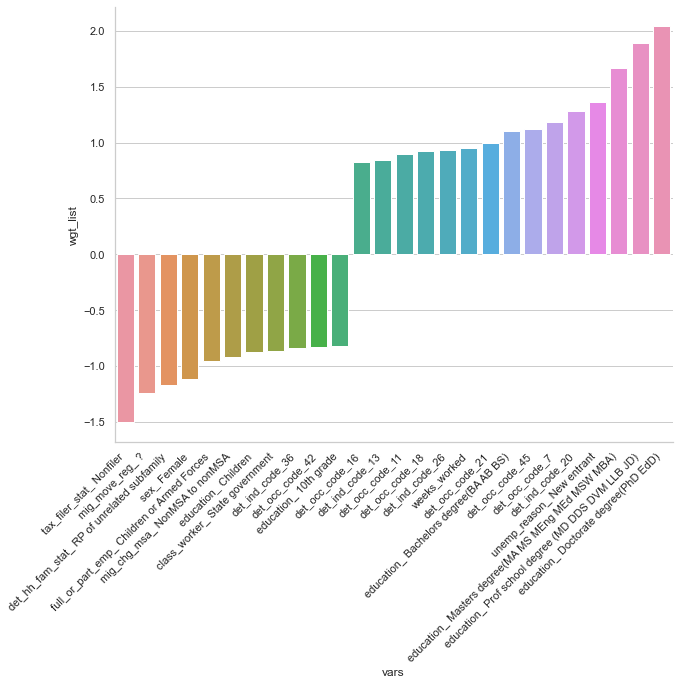

In [22]:
# Add sns plot
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weight_df=pd.DataFrame({"wgt_list":best_logistic_regression_coefs[0], "vars":all_cols})

sns.set(rc={'figure.figsize':(10, 8)})
# sns.set_context("paper", font_scale=0.9)
sns.set_style("whitegrid")

ax = sns.barplot(x= "vars", y="wgt_list", data= weight_df.loc[abs(weight_df['wgt_list']) > 0.8 ], order=weight_df.loc[abs(weight_df['wgt_list']) > 0.8].sort_values('wgt_list').vars)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.despine()

## Interpret Support Vectors

In [86]:
#Getting a classification report
from sklearn.metrics import classification_report
classified_report = classification_report(y_test, y_pred)
print(classified_report)

              precision    recall  f1-score   support

    - 50000.       0.94      1.00      0.97     28073
     50000+.       0.00      0.00      0.00      1856

    accuracy                           0.94     29929
   macro avg       0.47      0.50      0.48     29929
weighted avg       0.88      0.94      0.91     29929



In [25]:
#Look at support vectors
print(classifier.support_vectors_.shape)
print(classifier.support_.shape)
print(classifier.n_support_)
print(classifier.classes_)
print(classifier.support_)

(14728, 329)
(14728,)
[7364 7364]
[' - 50000.' ' 50000+.']
[    53     77     93 ... 119672 119680 119684]


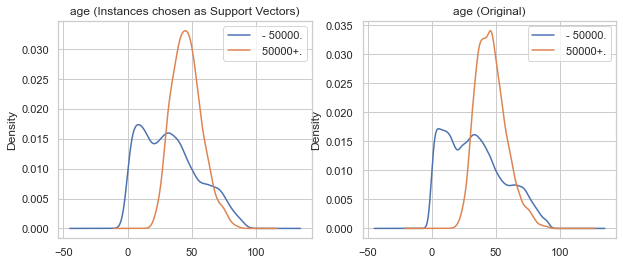

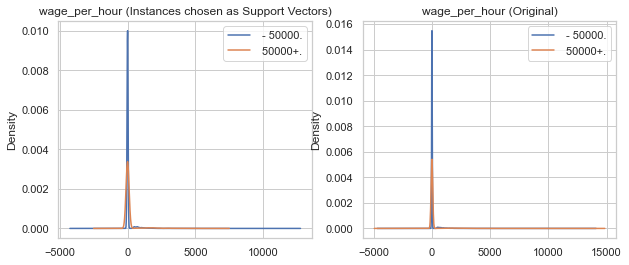

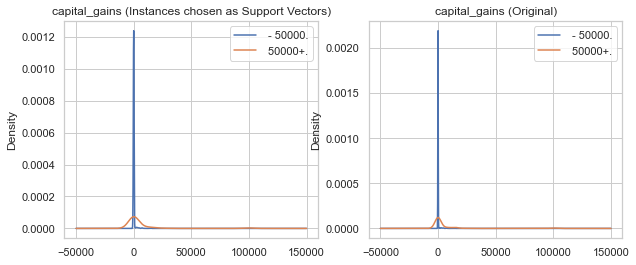

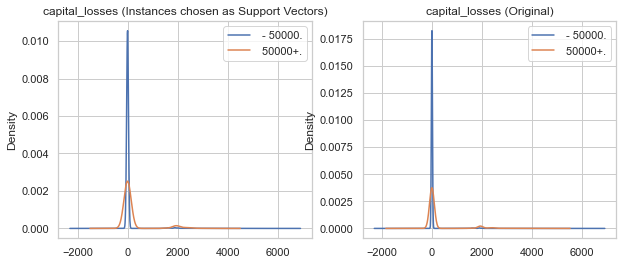

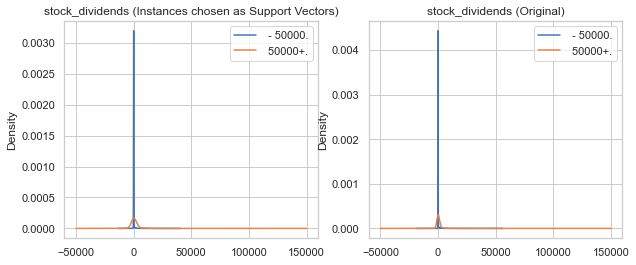

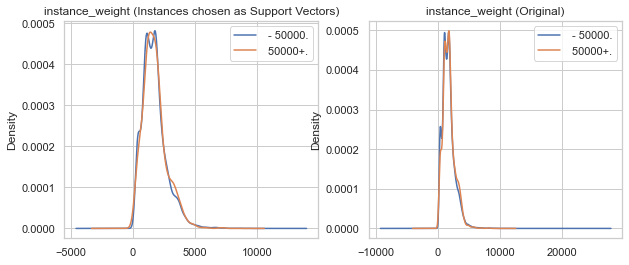

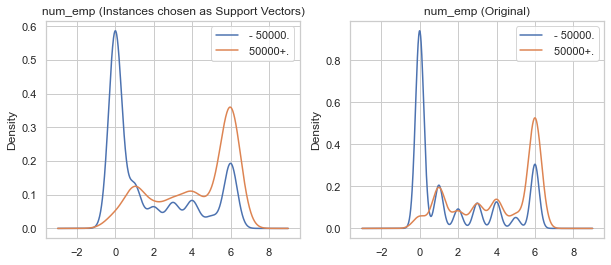

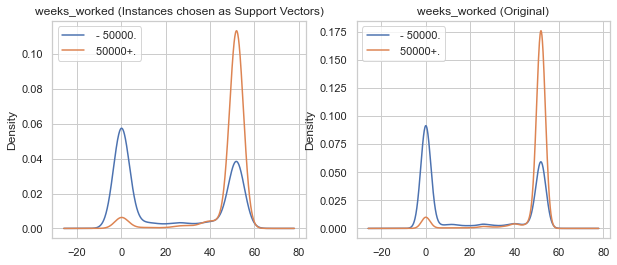

In [71]:
df_support = sampleDF.iloc[classifier.support_,:].copy()
vars_to_plot = numeric_features

df_grouped_support = df_support.groupby(['income_50k'])
df_grouped = sampleDF.groupby(['income_50k'])


Text(0.5, 1.0, 'weeks_worked (Original)')

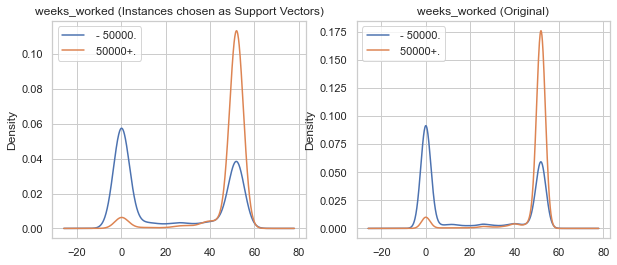

In [75]:
#for v in vars_to_plot:
plt.figure(figsize=(10,4))
# plot support vector stats
plt.subplot(1,2,1)
ax = df_grouped_support['weeks_worked'].plot.kde() 
plt.legend([' - 50000.', ' 50000+.'])
plt.title(v+' (Instances chosen as Support Vectors)')

plt.subplot(1,2,2)
ax = df_grouped['weeks_worked'].plot.kde() 
plt.legend([' - 50000.', ' 50000+.'])
plt.title(v+' (Original)')


In [80]:
def categorical_explanitory_binary_response_chart(chart_df, field, target, toggle=False, ):
    # the toggle switches which class is the "baseline" of the line chart
    drop_index = 2
    if toggle:
        drop_index = 1
    
    field_count  = chart_df[field].value_counts()
    field_count_df = field_count.to_frame()
    field_count_df.columns = ['count']
    
    field_target_pct = pd.crosstab(chart_df[field], chart_df[target], normalize='index') * 100
    field_target_pct = field_target_pct.reset_index()
    field_target_pct = field_target_pct.drop(field_target_pct.columns[-drop_index],axis=1)
    
    field_target_data = field_target_pct.merge(field_count_df, right_index=True, left_on=field).sort_values('count', ascending=False).reset_index(drop=True)
    
    print(field_target_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel(field)
    ax = sns.barplot(field_target_data[field], field_target_data['count'], alpha=0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_ylabel('count (bars)')
    ax2 = ax.twinx()
    ax2 = sns.pointplot(x=field_target_data[field], y=field_target_data.iloc[:, -2], color='black', legend=False)
    ax2.set_ylabel('% {t} (line)'.format(t = target))
    plt.show()


       sex    50000+.  count
0   Female   2.529489   7630
1     Male  10.834038   7098


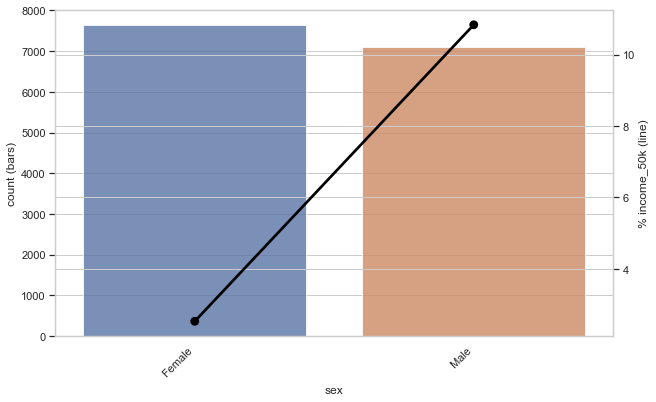

In [81]:
categorical_explanitory_binary_response_chart(df_support, 'sex', 'income_50k')

       sex    50000+.  count
0   Female   2.490463  77857
1     Male  10.142787  71785


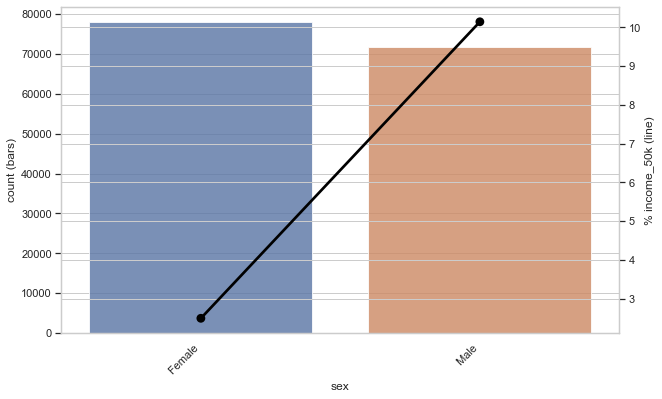

In [82]:
categorical_explanitory_binary_response_chart(sampleDF, 'sex', 'income_50k')

                                  education    50000+.  count
0                                  Children   0.000000   3537
1                      High school graduate   4.107245   3506
2                Some college but no degree   6.566876   2071
3                Bachelors degree(BA AB BS)  19.618529   1468
4                         7th and 8th grade   0.919118    544
5                                10th grade   0.184502    542
6                                11th grade   1.391650    503
7    Masters degree(MA MS MEng MEd MSW MBA)  33.606557    488
8                                 9th grade   1.257862    477
9       Associates degree-occup /vocational   8.845209    407
10       Associates degree-academic program  11.146497    314
11                         5th or 6th grade   0.384615    260
12                    12th grade no diploma   1.117318    179
13                 1st 2nd 3rd or 4th grade   2.083333    144
14   Prof school degree (MD DDS DVM LLB JD)  55.970149    134
15      

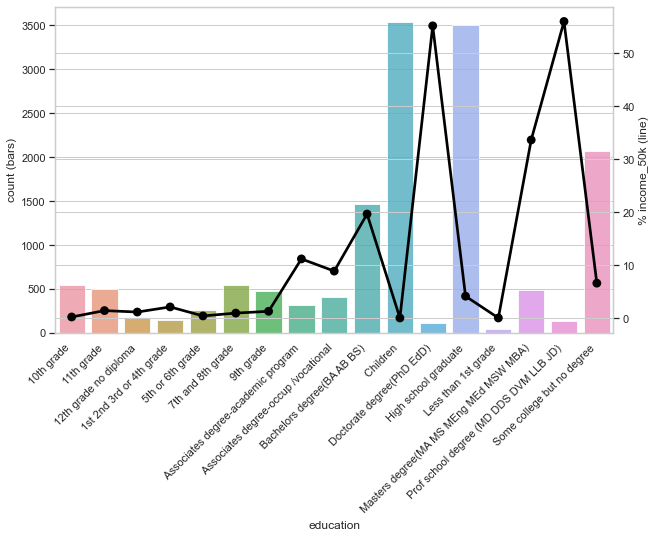

In [83]:
categorical_explanitory_binary_response_chart(df_support, 'education', 'income_50k')

                                  education    50000+.  count
0                      High school graduate   3.982104  35986
1                                  Children   0.000000  35639
2                Some college but no degree   6.069130  20975
3                Bachelors degree(BA AB BS)  19.662017  14912
4                         7th and 8th grade   0.980229   6019
5                                10th grade   0.851366   5638
6                                11th grade   1.040262   5191
7    Masters degree(MA MS MEng MEd MSW MBA)  31.048552   4902
8                                 9th grade   0.722789   4704
9       Associates degree-occup /vocational   7.933762   4046
10       Associates degree-academic program   9.121726   3245
11                         5th or 6th grade   0.885312   2485
12                    12th grade no diploma   1.440576   1666
13                 1st 2nd 3rd or 4th grade   0.865177   1387
14   Prof school degree (MD DDS DVM LLB JD)  55.220418   1293
15      

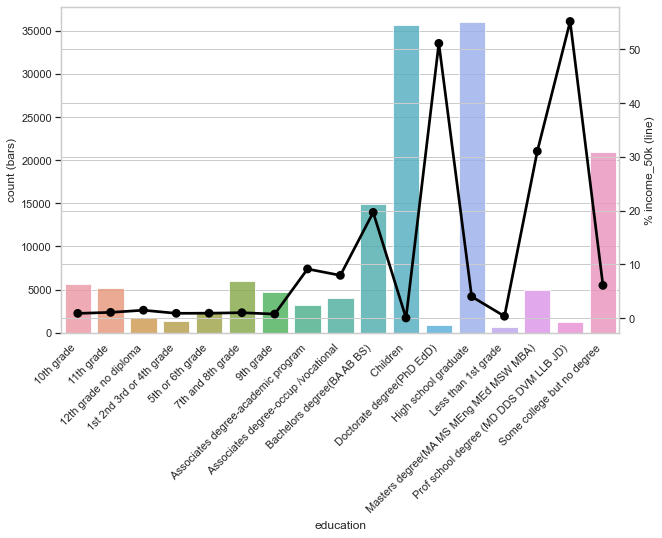

In [84]:
categorical_explanitory_binary_response_chart(sampleDF, 'education', 'income_50k')